# FINAL PROJECT: TUNING SOME MODELS

You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

# Competition description

This challenge serves as final project for the _"How to win a data science competition"_ Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - __1C Company__.

We are asking you to __predict total sales for every product and store in the next month__. By solving this competition you will be able to apply and enhance your data science skills.

### Submission File

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

`ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.`

### Team Limits

Three individuals.

### Submission Limits

You may submit a maximum of 5 entries per day (10 for Coursera).

### Metric

Submissions are evaluated by root mean squared error (__RMSE__). True target values are clipped into [0,20] range.

In [1]:
target_range = [0, 20]

### Leaderboard
By now lowest RMSE in PL is: `0.79215`
with `210` submissions

# Imports

In [2]:
import torch

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

import os, gc, math, time, datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import lightgbm as lgb
from sklearn import feature_extraction
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeRegressor

import data
from data import index_cols, index_cols_shop, future_index_cols
from features import target_cols
import features
import tools

import models
from models import scoring

%load_ext autoreload
%autoreload 2

In [4]:
import sklearn
import scipy.sparse 
for p in [np, pd, sklearn, scipy, torch, lgb]:
    print (p.__name__, p.__version__)

numpy 1.17.0
pandas 0.25.0
sklearn 0.21.3
scipy 1.3.0
torch 1.1.0
lightgbm 2.0.6


# Load features

Load features from disk.

In [5]:
all_data = features.load_features()

In [6]:
# Check
data.inspect_dataframe('ALL_DATA', all_data)


ALL_DATA (6639294, 44)
shop_id                       int32
item_id                       int32
date_block_num                int32
target                      float32
revenue                     float32
target_shop                 float32
revenue_per_shop            float32
target_item                 float32
revenue_per_item            float32
item_category_id              int32
target_category             float32
revenue_per_category        float32
target_item_price           float32
item_category_id_enc        float32
target_lag_1                float32
target_lag_2                float32
target_lag_3                float32
target_lag_4                float32
target_lag_5                float32
target_lag_12               float32
target_shop_lag_1           float32
target_shop_lag_2           float32
target_shop_lag_3           float32
target_shop_lag_4           float32
target_shop_lag_5           float32
target_shop_lag_12          float32
target_item_lag_1           float32
targ

,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
4488756,2,27,12,0.0,0.0,890.0,1032722.0,1.0,998.0,19,...,14113.0,18932.0,10488.0,8983.0,1048.000000,1198.000000,942.266663,1198.0,1198.000000,2325.0
4488757,2,30,12,0.0,0.0,890.0,1032722.0,58.0,9802.0,40,...,24173.0,23348.0,24130.0,0.0,167.330856,165.217392,205.524994,399.0,384.894745,0.0
4488758,2,31,12,0.0,0.0,890.0,1032722.0,15.0,7485.0,37,...,6950.0,7659.0,8680.0,0.0,499.000000,488.377777,543.528015,699.0,688.400024,0.0


,shop_id,item_id,date_block_num,target,revenue,target_shop,revenue_per_shop,target_item,revenue_per_item,item_category_id,...,target_category_lag_3,target_category_lag_4,target_category_lag_5,target_category_lag_12,target_item_price_lag_1,target_item_price_lag_2,target_item_price_lag_3,target_item_price_lag_4,target_item_price_lag_5,target_item_price_lag_12
11128047,59,22164,34,0.0,0.0,0.0,0.0,0.0,0.0,37,...,3426.0,3291.0,3756.0,0.0,549.000000,549.0,631.5,699.0,699.000000,0.0
11128048,59,22166,34,0.0,0.0,0.0,0.0,0.0,0.0,54,...,264.0,276.0,292.0,305.0,150.000000,150.0,150.0,150.0,150.000000,150.0
11128049,59,22167,34,0.0,0.0,0.0,0.0,0.0,0.0,49,...,571.0,669.0,699.0,760.0,293.895935,299.0,299.0,299.0,294.636353,299.0


# Dataset split

The dataset has a timeline, get last month of train as validation data.

And the month=34 is the X_test for final submission.

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = data.split(all_data)

Test data is where date_block_num=34
Validation data is where date_block_num=33

fit_cols: ['item_category_id', 'item_category_id_enc', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'target_lag_4', 'target_lag_5', 'target_lag_12', 'target_shop_lag_1', 'target_shop_lag_2', 'target_shop_lag_3', 'target_shop_lag_4', 'target_shop_lag_5', 'target_shop_lag_12', 'target_item_lag_1', 'target_item_lag_2', 'target_item_lag_3', 'target_item_lag_4', 'target_item_lag_5', 'target_item_lag_12', 'target_category_lag_1', 'target_category_lag_2', 'target_category_lag_3', 'target_category_lag_4', 'target_category_lag_5', 'target_category_lag_12', 'target_item_price_lag_1', 'target_item_price_lag_2', 'target_item_price_lag_3', 'target_item_price_lag_4', 'target_item_price_lag_5', 'target_item_price_lag_12'] 32 

train validation test total
6186922 238172 214200 6639294
6186922 238172 214200 6639294


# Simple Neural Network Regressor
Two layer NN Adam MES with early stopping

In [7]:
torch.manual_seed(1)    # reproducible

In [8]:
def nn_scoring(scoring_model, cols=None):
    scoring('NN', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, preds_transform=np.squeeze, cols=cols)   

In [9]:
num_feat = X_train.shape[1]
print('num_feat =',num_feat)

num_feat = 32


In [25]:
num_batches = 600
batch_size = 1024*int(len(X_train)/1024/num_batches)
print('batch_size =', batch_size )

# hyperparameters in example
#n_hidden1, n_hidden2, learning_rate, batch_size = 200, 100, 0.05, 64

# Basic params
nn_params = {
                'num_feat': num_feat, 
                'n_hidden1': 100, 
                'n_hidden2': 50, 
                'dropout': 0.2, 
                'optim_type': 'adam',
                'learning_rate': 0.001, 
                'batch_size': batch_size
            }

# Model with basic params
nn_model = models.NNRegressor(num_feat)
nn_model.set_params(**nn_params)
print(nn_model.get_params())

# Train the model
max_epochs = 100 # 2000 in the example
mid_validations = 0 # do N intermediate validations per epoch, slower
epoch_losses, val_losses = nn_model.train( 
                                           X_train.values,
                                           np.reshape(y_train.clip(*target_range),(y_train.shape[0],1)), # PRECLIP much better
                                           X_val.values,
                                           np.reshape(y_val.clip(*target_range),(y_val.shape[0],1)),
                                           max_epochs=max_epochs, 
                                           mid_validations=mid_validations, 
                                           verbosity=1 )

batch_size = 10240
model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 100, 'n_hidden2': 50, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 10240}

2019-08-05 13:35:56 ---- START training
2019-08-05 13:36:24 ---- END Epoch = 0/99 AvgLoss = 6208.4077 ValLoss = 2.0253
2019-08-05 13:36:52 ---- END Epoch = 1/99 AvgLoss = 54.1542 ValLoss = 1.4903
2019-08-05 13:37:19 ---- END Epoch = 2/99 AvgLoss = 37.4314 ValLoss = 1.4081
2019-08-05 13:37:47 ---- END Epoch = 3/99 AvgLoss = 29.9264 ValLoss = 1.3653
2019-08-05 13:38:14 ---- END Epoch = 4/99 AvgLoss = 24.0650 ValLoss = 1.3402
2019-08-05 13:38:41 ---- END Epoch = 5/99 AvgLoss = 19.3747 ValLoss = 1.3214
2019-08-05 13:39:09 ---- END Epoch = 6/99 AvgLoss = 15.5601 ValLoss = 1.3101
2019-08-05 13:39:36 ---- END Epoch = 7/99 AvgLoss = 12.5896 ValLoss = 1.2951
2019-08-05 13:40:04 ---- END Epoch = 8/99 AvgLoss = 10.1435 ValLoss = 1.2874
2019-08-05 13:40:31 ---- END Epoch = 9/99 AvgLoss = 8.1497 ValLoss = 1.2647
2019-08-05 13:41:02 ---- END E

Train RMSE for NN is 0.949817
Dev RMSE for NN is 0.983031


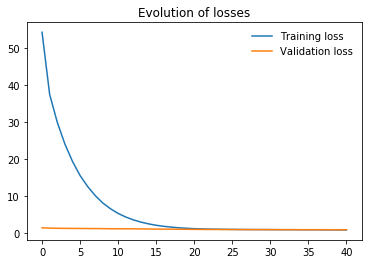

In [54]:
# See learning evolution 
nn_model.plot_training_evolution(loss_limit=None)

# Score
nn_scoring(nn_model)

### Do some TUNING for network nodes, batch_size and learning_rate
And be aware of training time, because later I want to execute a f) KFold scheme.

In [16]:
import models

In [14]:
def model_case(batch_size=10240, learning_rate=0.001, n_hidden=100, optim_type='adam', 
               plot_evolution=True, verbosity=0):
    
    # Set the model
    nn_params = {
                    'num_feat': num_feat, 
                    'n_hidden1': n_hidden, 
                    'n_hidden2': int(n_hidden/2), 
                    'dropout': 0.2, 
                    'optim_type': optim_type,
                    'learning_rate': learning_rate, 
                    'batch_size': batch_size
                }
    nn_model = models.NNRegressor(num_feat)
    nn_model.set_params(**nn_params)
    print(nn_model.get_params())

    # Train the model
    epoch_losses, val_losses = nn_model.train( 
                                               X_train.values,
                                               np.reshape(y_train.clip(*target_range),(y_train.shape[0],1)), 
                                               X_val.values,
                                               np.reshape(y_val.clip(*target_range),(y_val.shape[0],1)),
                                               max_epochs=100, 
                                               mid_validations=0, 
                                               verbosity=verbosity )
    # See learning evolution 
    if plot_evolution:
        nn_model.plot_training_evolution(loss_limit=1.5)

    # Score
    nn_scoring(nn_model)
    
    return epoch_losses, val_losses, nn_model

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 600, 'n_hidden2': 300, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.001, 'batch_size': 10240}

2019-08-06 01:01:07 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 01:18:32 *** Early stop at epoch 37/99, best_ValLoss = 0.9739
2019-08-06 01:18:32 --- DONE Epoch = 37/99 AvgLoss = 0.9987 ValLoss = 0.9787



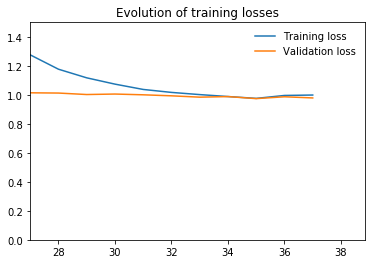

In [ ]:
# 600 network
el, vl, m = model_case(n_hidden=600)

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.001, 'batch_size': 10240}

2019-08-06 10:12:05 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 10:29:18 *** Early stop at epoch 36/99, best_ValLoss = 0.9516
2019-08-06 10:29:18 --- DONE Epoch = 36/99 AvgLoss = 0.9148 ValLoss = 0.9556



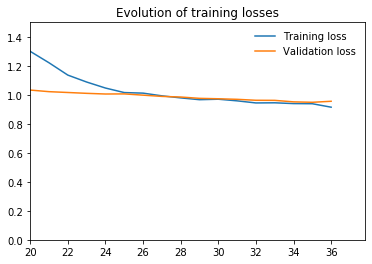

Train RMSE for NN is 0.937139
Dev RMSE for NN is 0.976706


In [15]:
# 200 nodes
el, vl, m = model_case(n_hidden=200)

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}

2019-08-06 00:06:02 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 00:37:54 *** Early stop at epoch 38/99, best_ValLoss = 0.9259
2019-08-06 00:37:54 --- DONE Epoch = 38/99 AvgLoss = 0.8298 ValLoss = 0.9263



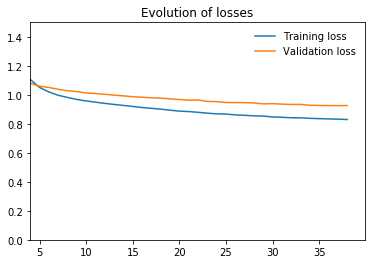

Train RMSE for NN is 0.910046
Dev RMSE for NN is 0.959168


In [65]:
# 200 nodes and tune batch_size
el, vl, m = model_case(batch_size=1024, learning_rate=1e-4, n_hidden=200)

In [ ]:
# Combine BATCH SIZE and LEARNING RATE
total_el, total_vl = {}, {}
a_bs = [2048, 1024, 512, 256, 128]
a_lr = [5e-4, 1e-4, 5e-5, 1e-5, 1e-5]

for i,batch_size in enumerate(a_bs):
    learning_rate = a_lr[i]
    seguir = input('seguir...')
    if seguir == 'N':
        break
    el, vl, m = model_case(batch_size=batch_size, learning_rate=learning_rate, n_hidden=200, plot_evolution=False)
    total_el[batch_size] = el
    total_vl[batch_size] = vl

# Decission Tree Regressor

Only one decission tree (not an ensemble)

In [8]:
def dtr_scoring(scoring_model, cols=None):
    scoring('DTR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)

In [9]:
# Base params
dtr_params = {
                'random_state': 0, # Changing this could generate ensembling options

                'max_depth': None,
                'max_features': None,
                'max_leaf_nodes': None,
                'min_impurity_decrease': 0.0,
                'min_impurity_split': None,
                'min_samples_leaf': 1,
                'min_samples_split': 2,
                'min_weight_fraction_leaf': 0.0,

                'presort': False,
                'splitter': 'best',
                'criterion': 'mse'
                }

# Fit with base params
t_start = time.time()
dtr_model = DecisionTreeRegressor()
dtr_model = dtr_model.set_params(**dtr_params)
dtr_model = dtr_model.fit(X_train.values, y_train.clip(*target_range)) # PRECLIP
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 264.80


In [13]:
# Score
dtr_scoring(dtr_model)

Train RMSE for DTR is 0.504024
Dev RMSE for DTR is 1.171550


# Linear Regressor

Simple LinearRegression

In [7]:
def lr_scoring(scoring_model, cols=None):
    scoring('LR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)
    
# Fit
t_start = time.time()
lr_model = LinearRegression()
res = lr_model.fit(X_train.values, y_train) # POSTCLIP works better
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 11.52


In [8]:
# Score
lr_scoring(lr_model)

Train RMSE for LR is 0.965304
Dev RMSE for LR is 1.001641


It is not very promising and no tuning options...

# ElasticNet
A more sophisticated linear regressor.

In [8]:
def en_scoring(scoring_model, cols=None):
    scoring('EN', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)

Basic learning with default parameters:

In [9]:
def get_en_params(alpha=1.0, l1_ratio=0.5, max_iter=1000):
    return {
                 'max_iter': max_iter,
                 'random_state': 0, # Changing this could generate ensembling options
    
                 'alpha': alpha,
                 'l1_ratio': l1_ratio,

                 'tol': 0.0001,
                 'fit_intercept': True,
                 'normalize': False,
                 'positive': False,
                 'precompute': False,
                 'selection': 'cyclic',
                 'copy_X': True,
                 'warm_start': False
            }
    

In [13]:
# Default params
en_params = get_en_params()

# Fit to train with default parameters
t_start = time.time()
en_model = ElasticNet()
en_model = en_model.set_params(**en_params)
en_model = en_model.fit(X_train.values, y_train) # POSTCLIP
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 67.88


In [14]:
# Score
en_scoring(en_model)

Train RMSE for EN is 0.956561
Dev RMSE for EN is 0.991646


Do a tuning with CV function, and get the final best parameters:

In [9]:
# Prepare cross validation data
X = X_train.append(X_val)
Y = np.concatenate([y_train, y_val])
train_ind=np.zeros(X.shape[0])
for i in range(0, len(X_train)):
    train_ind[i] = -1
ps = PredefinedSplit(test_fold=(train_ind))

# Base params
max_iter = 1000
alphas = None
#alphas = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
n_alphas = 100
l1_ratio = [.1, .3, .5, .7, .9, .95, .99, 1]
ecv_params = {  'cv': ps,
                 'n_jobs': 4,
               
                 'max_iter': max_iter,
                 'random_state': 0, # Changing this could do ensembling options
    
                 'alphas': alphas,
                 'n_alphas': n_alphas,
                 'l1_ratio': l1_ratio,

                 'eps': 0.001,

                 'tol': 0.0001,
                 'fit_intercept': True,
                 'normalize': False,
                 'positive': False,
                 'precompute': False,
                 'selection': 'cyclic',
                 'copy_X': True,

                'verbose': 2
            }

# Tune
ecv = ElasticNetCV()
ecv = ecv.set_params(**ecv_params)
ecv = ecv.fit(X, Y) # POSTCLIP

Path: 000 out of 100
Path: 000 out of 100Path: 000 out of 100

Path: 000 out of 100
Path: 001 out of 100
Path: 001 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 005 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 006 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 011 out of 100
Path: 012 out

Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 094 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 096 out of 100
Path: 092 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 095 out of 100
Path: 022 out of 100
Path: 097 out of 100
Path: 093 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 096 out of 100
Path: 026 out of 100
Path: 098 out of 100
Path: 094 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 099 out of 100
Path: 097 out of 100
Path: 095 out of 100
Path: 030 out of 100
Path: 000 out of 100
Path: 031 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 032 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 033 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out

Path: 096 out of 100
Path: 094 out of 100
Path: 092 out of 100
Path: 097 out of 100
Path: 095 out of 100
Path: 093 out of 100
Path: 098 out of 100
Path: 096 out of 100
Path: 094 out of 100
Path: 099 out of 100


[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed: 203.1min remaining: 67.7min


Path: 095 out of 100
Path: 097 out of 100
Path: 096 out of 100
Path: 098 out of 100
Path: 097 out of 100
Path: 099 out of 100
Path: 098 out of 100
Path: 099 out of 100


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed: 208.0min finished


In [10]:
# Score
en_scoring(ecv)

Train RMSE for EN is 0.960584
Dev RMSE for EN is 0.995787


No better than default parameters...

In [11]:
# Get best estimator parameters
best_params = ( ecv.alpha_, ecv.l1_ratio_, ecv.n_iter_)
print(best_params)
(alpha, l1_ratio, n_iter) = best_params

(0.40476141516829994, 1.0, 93)


Fit with optimized CV parameters:

In [23]:
# Best params
#alpha, l1_ratio, n_iter = 0.7092, 0.5, 370
alpha, l1_ratio, n_iter = 0.404, 1.0, 92

max_iter = 1000
en_params = get_en_params(alpha, l1_ratio, max_iter)

# Fit to train with best parameters
print(datetime.datetime.now())
t_start = time.time()
en_model = ElasticNet()
en_model = en_model.set_params(**en_params)
en_model = en_model.fit(X_train.values, y_train) # POSTCLIP
print("elapsed time: %.2f" % (time.time() - t_start))

2019-08-05 13:12:12.916598
elapsed time: 72.79


In [24]:
# Score
en_scoring(en_model)

Train RMSE for EN is 0.958163
Dev RMSE for EN is 0.994388


The ElasticNetCV chosen parameters do not improve default params accuracy ¿¿??

Try some manual tuning:

In [10]:
# Other params alpha, l1_ratio
max_iter = 1000
params = [  (1.0, 0.5),
            (1.0, 1.0),
            (1.0, 0.1),
            (0.5, 0.5),
            (0.5, 1.0),
            (0.5, 0.1)]

for p in params:
    print("\nUSING alpha, l1_ratio =",p)
    alpha, l1_ratio = p
    en_params = get_en_params(alpha, l1_ratio, max_iter)

    # Fit
    print(datetime.datetime.now())
    t_start = time.time()
    en_model = ElasticNet()
    en_model = en_model.set_params(**en_params)
    en_model = en_model.fit(X_train.values, y_train) # POSTCLIP
    print("elapsed time: %.2f" % (time.time() - t_start))
    
    # Score
    en_scoring(en_model)


USING alpha, l1_ratio = (1.0, 0.5)
2019-08-05 13:18:45.908675
elapsed time: 24.66
Train RMSE for EN is 0.956561
Dev RMSE for EN is 0.991646

USING alpha, l1_ratio = (1.0, 1.0)
2019-08-05 13:19:13.589477
elapsed time: 21.86
Train RMSE for EN is 0.953815
Dev RMSE for EN is 0.992727

USING alpha, l1_ratio = (1.0, 0.1)
2019-08-05 13:19:38.539472
elapsed time: 30.48
Train RMSE for EN is 0.961252
Dev RMSE for EN is 0.994526

USING alpha, l1_ratio = (0.5, 0.5)
2019-08-05 13:20:12.029422
elapsed time: 29.63
Train RMSE for EN is 0.959750
Dev RMSE for EN is 0.995003

USING alpha, l1_ratio = (0.5, 1.0)
2019-08-05 13:20:44.813310
elapsed time: 24.89
Train RMSE for EN is 0.956952
Dev RMSE for EN is 0.993560

USING alpha, l1_ratio = (0.5, 0.1)
2019-08-05 13:21:12.761309
elapsed time: 32.47
Train RMSE for EN is 0.962833
Dev RMSE for EN is 0.997439


# LightGBM

Tune a base LightGBM model.

In [8]:
# Function to score to test and validation
def lgb_scoring(scoring_model, cols=None):
    scoring('LGBM', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=False, cols=cols)

# Function to get parameters
def lgb_get_params(lr):
    return {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': lr, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

In [15]:
lgb_lr = 0.03
lgb_iterations = 1000
lgb_params = lgb_get_params(lgb_lr)

# Fit with early stopping to check the iterations (tuning)
model_early = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                        num_boost_round=lgb_iterations,
                        valid_sets=[lgb.Dataset(X_val, label=y_val.clip(*target_range))], 
                        valid_names=['val'], 
                        early_stopping_rounds=3)

[1]	val's rmse: 1.12483
Training until validation scores don't improve for 3 rounds.
[2]	val's rmse: 1.11375
[3]	val's rmse: 1.10479
[4]	val's rmse: 1.09599
[5]	val's rmse: 1.08648
[6]	val's rmse: 1.07892
[7]	val's rmse: 1.0704
[8]	val's rmse: 1.06238
[9]	val's rmse: 1.05461
[10]	val's rmse: 1.04728
[11]	val's rmse: 1.04046
[12]	val's rmse: 1.03426
[13]	val's rmse: 1.02834
[14]	val's rmse: 1.02377
[15]	val's rmse: 1.0184
[16]	val's rmse: 1.01343
[17]	val's rmse: 1.00862
[18]	val's rmse: 1.00403
[19]	val's rmse: 1.00032
[20]	val's rmse: 0.996231
[21]	val's rmse: 0.992354
[22]	val's rmse: 0.988654
[23]	val's rmse: 0.985796
[24]	val's rmse: 0.982618
[25]	val's rmse: 0.980035
[26]	val's rmse: 0.977185
[27]	val's rmse: 0.974595
[28]	val's rmse: 0.972
[29]	val's rmse: 0.969548
[30]	val's rmse: 0.96732
[31]	val's rmse: 0.96518
[32]	val's rmse: 0.963157
[33]	val's rmse: 0.961252
[34]	val's rmse: 0.959434
[35]	val's rmse: 0.957943
[36]	val's rmse: 0.956401
[37]	val's rmse: 0.954839
[38]	val's r

In [16]:
# Score to Train and Validation
lgb_scoring(model_early)

Train RMSE for RMSE is 0.847840
Dev RMSE for RMSE is 0.931783


In [19]:
del(model_early)
gc.collect()

256

In [27]:
# Chosen parameters for LightGBM
lgb_lr = 0.03
lgb_iterations = 110
lgb_params = lgb_get_params(lgb_lr)

# Fit to train
print(datetime.datetime.now())
t_start = time.time()
lgb_model = lgb.train(lgb_params, 
                  lgb.Dataset(X_train, label=y_train.clip(*target_range)), 
                  num_boost_round=lgb_iterations)
print("elapsed time: %.2f" % (time.time() - t_start))

2019-08-03 22:32:27.147582
elapsed time: 188.83


In [28]:
# Score 0.03 and 100
# Train RMSE for RMSE is 0.853100
# Dev RMSE for RMSE is 0.932555

# Score 0.03 and 120
#Train RMSE for RMSE is 0.846282
#Dev RMSE for RMSE is 0.931890

#Score 0.03 and 110
lgb_scoring(lgb_model)

Train RMSE for RMSE is 0.849565
Dev RMSE for RMSE is 0.931882


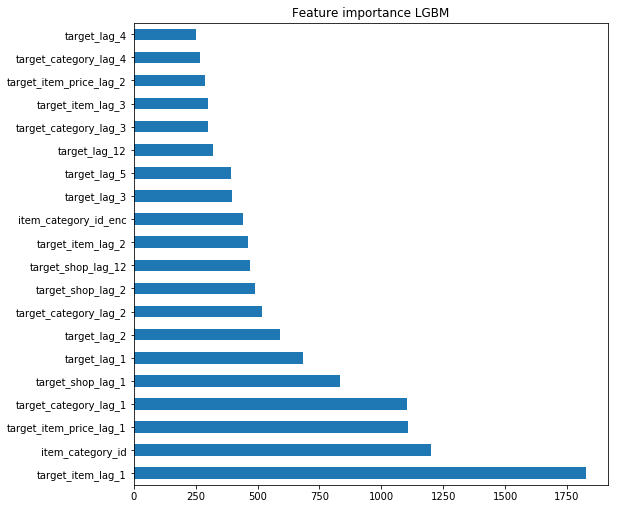

In [29]:
# Check importance of features
feat_importances = pd.Series(lgb_model.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
ax = feat_importances.plot(kind='barh')
p = plt.title('Feature importance LGBM')
p = plt.gcf().set_size_inches(8.5, 8.5)
p = plt.show()

In [9]:
# Check the impact of training with less features (the more important ones)

fit_cols_lgb = ['item_category_id', 'item_category_id_enc', 
'target_lag_1',            'target_lag_2',            'target_lag_3',            'target_lag_12', 
'target_shop_lag_1',       'target_shop_lag_2',       'target_shop_lag_3',       'target_shop_lag_12', 
'target_item_lag_1',       'target_item_lag_2',       'target_item_lag_3',       'target_item_lag_12', 
'target_category_lag_1',   'target_category_lag_2',   'target_category_lag_3',   'target_category_lag_12',
'target_item_price_lag_1', 'target_item_price_lag_2', 'target_item_price_lag_3', 'target_item_price_lag_12']

lgb_lr = 0.03
lgb_iterations = 110
lgb_params = lgb_get_params(lgb_lr)

# Fit to train
t_start = time.time()
X_train_small = X_train[fit_cols_lgb]
lgb_model2 = lgb.train(lgb_params, lgb.Dataset(X_train_small, label=y_train), num_boost_round=lgb_iterations)
print("elapsed time: %.2f" % (time.time() - t_start))

elapsed time: 126.80


In [10]:
# Score with less features
lgb_scoring(lgb_model2, fit_cols_lgb)

Train RMSE for LGBM is 0.868567
Dev RMSE for LGBM is 0.977681


In [35]:
del(lgb_model)
del(lgb_model2)
gc.collect()

114

# Correlation between models
They should be not very correlated to make a good first level ensemble mates.

By the correlation observation I can select a better 2-nd level model.

In [35]:
import models


Fit LR
2019-08-04 19:53:34.697513
elapsed training time: 10.99
 ** predictions clipping to [0, 20]
elapsed infer time: 0.11
 ** predictions clipping to [0, 20]
Dev RMSE for LR is 1.001641

Fit LightGBM
2019-08-04 19:53:45.793872
 ** predictions clipping to [0, 20]
elapsed training time: 189.67
 ** predictions clipping to [0, 20]
elapsed infer time: 2.74
 ** predictions clipping to [0, 20]
Dev RMSE for LightGBM is 0.931882

Predicting for train...
 ** predictions clipping to [0, 20]
elapsed infer time: 2.79
 ** predictions clipping to [0, 20]
elapsed infer time: 74.07

Predicting for dev...
 ** predictions clipping to [0, 20]
elapsed infer time: 0.07
 ** predictions clipping to [0, 20]
elapsed infer time: 2.66


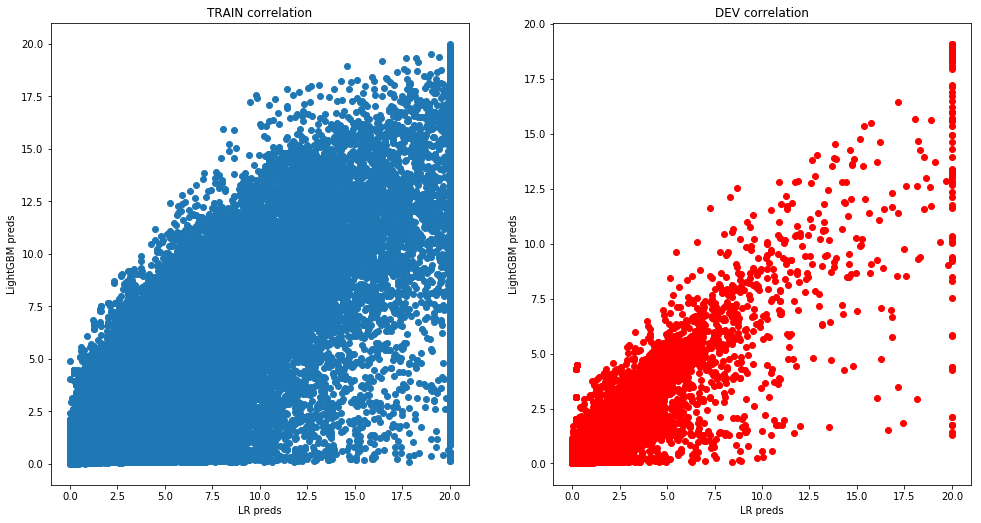

In [20]:
# LinearRegressor and LightGBM
m1 = models.modelLR(target_range)
m2 = models.modelLGB(target_range)
models.compare_models(m1, m2, X_train, y_train, X_val, y_val)


Fit ElasticNet
2019-08-05 20:50:50.683247
elapsed training time: 24.45
 ** predictions clipping to [0, 20]
elapsed infer time: 0.11
 ** predictions clipping to [0, 20]
Dev RMSE for ElasticNet is 0.991646

Fit LightGBM
2019-08-05 20:51:15.272227
 ** predictions clipping to [0, 20]
elapsed training time: 161.20
 ** predictions clipping to [0, 20]
elapsed infer time: 3.19
 ** predictions clipping to [0, 20]
Dev RMSE for LightGBM is 0.932113

Predicting for train...
 ** predictions clipping to [0, 20]
elapsed infer time: 2.71
 ** predictions clipping to [0, 20]
elapsed infer time: 84.80

Predicting for dev...
 ** predictions clipping to [0, 20]
elapsed infer time: 0.12
 ** predictions clipping to [0, 20]
elapsed infer time: 3.30


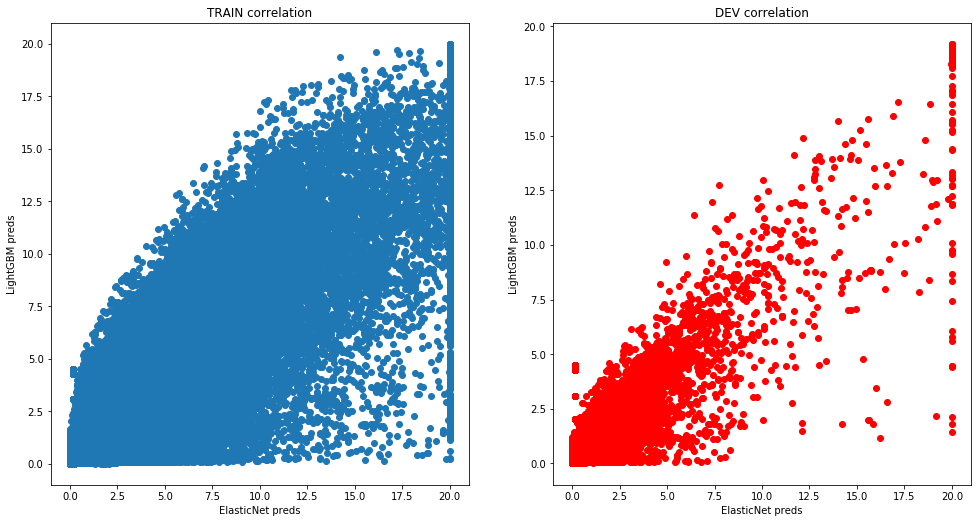

In [12]:
# ElasticNet and LightGBM
m1 = models.modelEN(target_range)
m2 = models.modelLGB(target_range)
models.compare_models(m1, m2, X_train, y_train, X_val, y_val)

model in GPU
model in GPU
{'num_feat': 32, 'n_hidden1': 200, 'n_hidden2': 100, 'dropout': 0.2, 'optim_type': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024}

Fit NNR
2019-08-06 02:50:46.535768
 ** predictions clipping to [0, 20]
 ** predictions clipping to [0, 20]

2019-08-06 02:50:49 ---- START training
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
2019-08-06 03:19:08 *** Early stop at epoch 34/99, best_ValLoss = 0.9341
2019-08-06 03:19:08 --- DONE Epoch = 34/99 AvgLoss = 0.8369 ValLoss = 0.9377

elapsed training time: 1701.99
 ** predictions clipping to [0, 20]
elapsed infer time: 0.15
 ** predictions clipping to [0, 20]
Dev RMSE for NNR is 0.965313

Fit LightGBM
2019-08-06 03:19:08.709428
 ** predictions clipping to [0, 20]
elapsed training time: 154.93
 ** predictions clipping to [0, 20]
elapsed infer time: 3.11
 ** predictions clipping to [0, 20]
Dev RMSE for LightGBM is 0.932113

Predicting for train...
 ** predictions clipping to [0, 20]
elapsed i

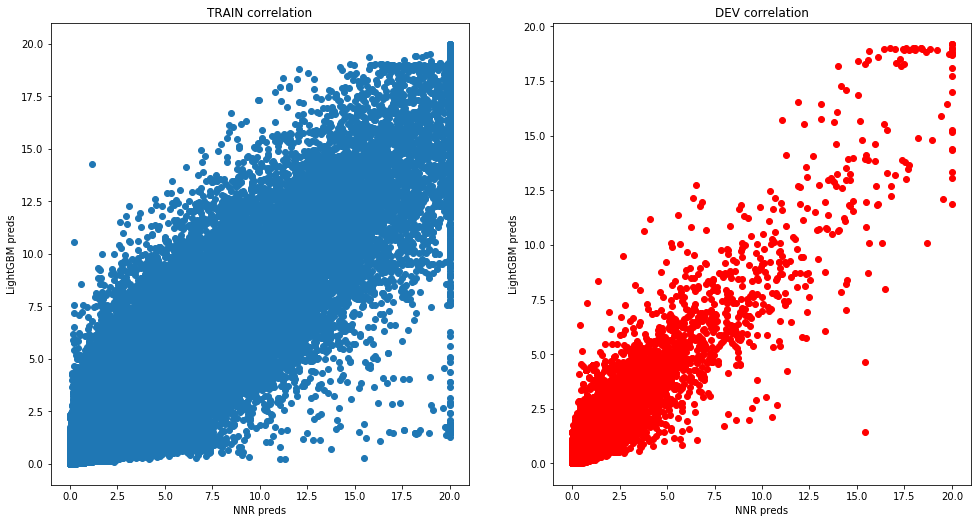

In [10]:
# NNRegressor and LightGBM
m1 = models.modelNNR(target_range)
m2 = models.modelLGB(target_range)
models.compare_models(m1, m2, X_train, y_train, X_val, y_val, m1_early=True)

# Random Forest Regressor

RendomForest regressor.

In [10]:
def rfr_scoring(scoring_model, cols=None):
    scoring('RFR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)

# Base params
#n_estimators = 10 # by default
n_estimators = 300
rfr_params = {
             'random_state': 0, # Changing this could do ensembling options
             'n_jobs': 4,

             'n_estimators': n_estimators,

             'bootstrap': True,
             'max_depth': None,
             'max_features': 'auto',
    
             'max_leaf_nodes': None,
             'min_impurity_decrease': 0.0,
             'min_impurity_split': None,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'min_weight_fraction_leaf': 0.0,

             'criterion': 'mse',
             'oob_score': False,
             'warm_start': False,

             'verbose': 2,
            }

# Fit to train with base parameters
print(datetime.datetime.now())
t_start = time.time()
rfr_model = RandomForestRegressor()
rfr_model = rfr_model.set_params(**rfr_params)
rfr_model = rfr_model.fit(X_train.values, y_train.clip(*target_range))
print("elapsed time: %.2f" % (time.time() - t_start))

2019-08-04 01:00:16.731382
building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300building tree 18 of 300

building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 60.0min


building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c8bfc82b04c2>", line 36, in <module>
    rfr_model = rfr_model.fit(X_train.values, y_train)
  File "/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/site-packages/sklearn/ensemble/forest.py", line 327, in fit
    for i, t in enumerate(trees))
  File "/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 789, in __call__
    self.retrieve()
  File "/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 699, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/mar/miniconda3/envs/coursera-kaggle/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/Us

KeyboardInterrupt: 

In [ ]:
# Score 300 estimators
rfr_scoring(rfr_model)

In [11]:
# Score 10 estimators
rfr_scoring(rfr_model)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   12.4s finished


Train RMSE for RFR is 0.604763


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished


Dev RMSE for RFR is 1.059397


TAKES HOURS TO TRAIN only one model, not suitable for the f) kfolf scheme

In [ ]:
from models import grid_search_tuning

# Tune in GridSearch with CV
estimator = RandomForestRegressor(n_estimators=n_estimators, n_jobs=4)
param_grid={'bootstrap':[0.7, 0.8], 'max_features':[4, 6, 8], 
            'max_depth' : [None, 4, 6, 8, 10, 12]}
best_params = grid_search_tuning(estimator, param_grid, X_train, y_train.clip(*target_range), 
                                 X_val, y_val.clip(*target_range))

In [ ]:
feat_importances = pd.Series(rf_model.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
ax = feat_importances.plot(kind='barh', color='green')
p = plt.title('Feature importance RF')
p = plt.gcf().set_size_inches(8.5, 8.5)
p = plt.show()

# KNN Regressor

KNeighborsRegressor

In [ ]:
def knnr_scoring(scoring_model, cols=None):
    scoring('KNNR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)

# Base params
# n_neighbors=5, leaf_size=30 by default, but it takes too long to be trained
knnr_params = {
                 'n_jobs': 4,
    
                 'n_neighbors': 3,
                 'leaf_size': 10,

                 'metric': 'minkowski',
                 'metric_params': None,
                 'p': 2,

                 'algorithm': 'auto',
                 'weights': 'uniform'
                }

# Fit to train with base parameters
t_start = time.time()
knnr_model = KNeighborsRegressor()
knnr_model = knnr_model.set_params(**knnr_params)
knnr_model = knnr_model.fit(X_train.values, y_train.clip(*target_range))
print("elapsed time: %.2f" % (time.time() - t_start))

In [ ]:
# Score
knnr_scoring(knnr_model)

TOO SLOW!!! UNABLE TO TRAIN

# SVR
Support vector machine regressor

In [ ]:
def svr_scoring(scoring_model, cols=None):
    scoring('SVR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)

# Default params
max_iter = -1
svr_params = {
               'max_iter': max_iter, 
               'cache_size': 200,
    
               'C': 1.0, 
               'coef0': 0.0,
               'degree': 3,
               'epsilon': 0.0, 
               'gamma': 'auto', 

               'kernel': 'rbf',
               'shrinking': True, 
               'tol': 0.0001, 
               'verbose': 2
            }

# Fit to train
t_start = time.time()
svr_model = SVR()
svr_model = svr_model.set_params(**svr_params)
svr_model = svr_model.fit(X_train.values, y_train.clip(*target_range))
print("elapsed time: %.2f" % (time.time() - t_start))

[LibLinear]

In [ ]:
# Score
svr_scoring(svr_model)

TOO SLOW TRAINING!!!

# Polynomial Regressor
Fit higher order curves.

In [10]:
def pr_scoring(scoring_model, cols=None):
    scoring('PR', scoring_model, target_range,
            X_train, y_train, X_val, y_val, values=True, cols=cols)
    
# Default parameters
pr_parameters = {'degree': 2, 'include_bias': True, 'interaction_only': False}

# Fit to train with defaults
print(datetime.datetime.now())
t_start = time.time()
pr_feat = PolynomialFeatures()
pr_feat = pr_feat.set_params(**pr_parameters)
pr_model = Pipeline([('poly', pr_feat),('linear', LinearRegression(fit_intercept=False))])
pr_model = pr_model.fit(X_train.values, y_train.clip(*target_range))
print("elapsed time: %.2f" % (time.time() - t_start))

2019-08-03 22:57:23.198236



KeyboardInterrupt



In [ ]:
# Score
pr_scoring(pr_model)

TOO SLOW!!! UNABLE TO TRAIN, AND MEMORY FULL

# Future work

Because of a lack of time and computation power I have left behind some aspects that could improve the solution:

* XGBoost, CatBoost
* More complex Neural Network elements for regression in timeseries (LSTM, GRU), or even better tuning of the naive approach I've done
